In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,re
import seaborn as sns

### signature heatmap

In [86]:
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

def signature_proportion_heatmap(sig_matrix,label_df,order,legend_prefix,output,format = 'png') :
    
    metadata_df = label_df.sort_values(by=order)
    plot_df = sig_matrix.loc[:,metadata_df.index].T
    
    cmap = sns.light_palette("darksalmon", as_cmap=True)
    #cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)
    cluster1 = metadata_df[order[0]].values
    cluster1_lut = dict(zip( set(cluster1),  [cm.Set2(x) for x in range(10)] )) # type: ignore
    cluster1_colors = pd.Series(cluster1).map(cluster1_lut)
    cluster1_colors.index = metadata_df.index
    
    if len(order) == 1 :
    
        g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                    row_cluster=False, 
                    col_cluster=False,
                    row_colors=[cluster1_colors[plot_df.index]],
                    linewidths=0, figsize=(6,12))
        g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
        g.cax.set_title("Signature proportion",fontsize = 10)# type: ignore

        for label in sorted(set(cluster1)):
            g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0.5)
        l1 = g.ax_col_dendrogram.legend(title=legend_prefix, loc="center", ncol=5, bbox_to_anchor=(0.47, .9), bbox_transform=plt.gcf().transFigure) # type: ignore
    else :

        cluster2 = metadata_df.loc[:,order[1]].values
        cluster2_lut = dict(zip( set(cluster2),  [cm.Set3(x) for x in range(10)] ))# type: ignore
        cluster2_colors = pd.Series(cluster2).map(cluster2_lut)
        cluster2_colors.index = metadata_df.index

        cmap = sns.light_palette("darksalmon", as_cmap=True)
        #cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)

        g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                        row_cluster=False, 
                        col_cluster=False,
                        row_colors=[cluster1_colors[plot_df.index],cluster2_colors[plot_df.index]],
                        linewidths=0, figsize=(6,10))
        g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
        g.cax.set_title("Signature proportion",fontsize = 10)# type: ignore

        
        for label in sorted(set(cluster1)):
            g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0)
        l1 = g.ax_col_dendrogram.legend(title=order[0] + ' ' + legend_prefix, loc="center", ncol=5, bbox_to_anchor=(0.47, 1.0), bbox_transform=plt.gcf().transFigure) # type: ignore
    
        for label in sorted(set(cluster2)):
            g.ax_row_dendrogram.bar(0, 0, color=cluster2_lut[label], label=label, linewidth=0)
        l2 = g.ax_row_dendrogram.legend(title=order[1] + ' ' + legend_prefix, loc="center", ncol=5, bbox_to_anchor=(0.47, .9), bbox_transform=plt.gcf().transFigure) # type: ignore

    plt.savefig(output,dpi = 300,bbox_inches = 'tight',format = format)

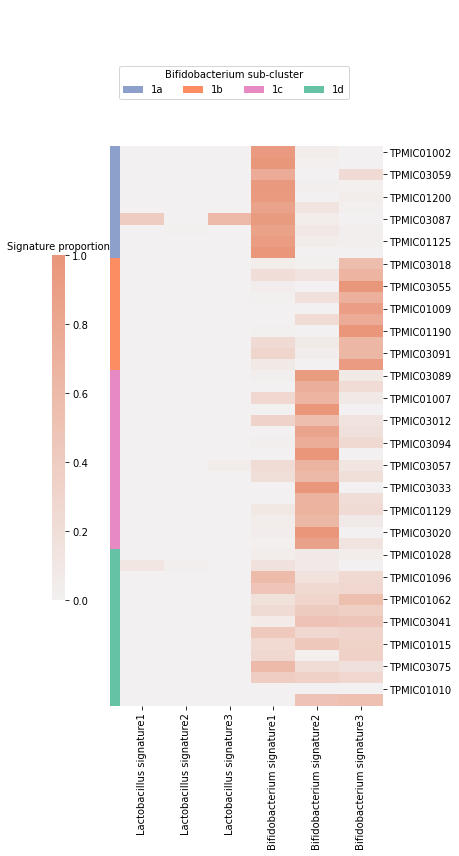

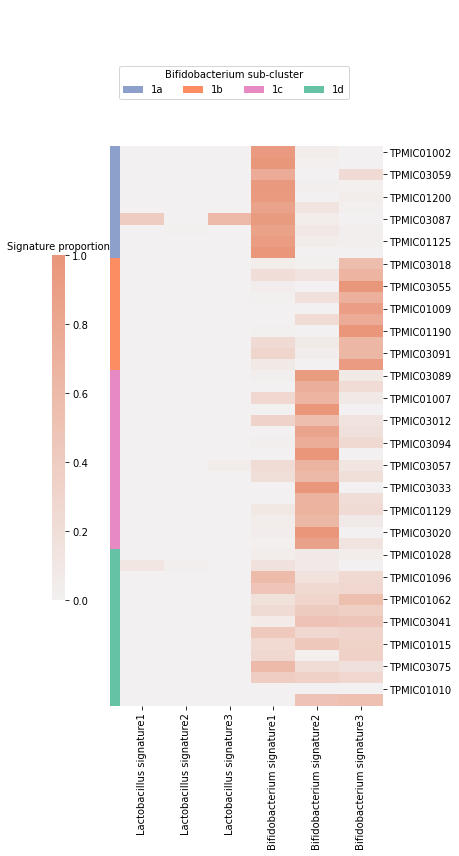

In [90]:
condition = ['MCI']
rogosae = ['without_rogosae']
for con in condition :
    for rog in rogosae :
        cluster = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/%s/consensus/consensus_clustering_with_sub_cluster.txt" % (con),sep='\t',index_col=0)
        matrix = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3/%s/consensus/signature_proportion_matrix_%s.txt" % (con,rog),sep='\t',index_col=0)
        idx = np.where(cluster['cluster'] == 1,True,False)
        sample = list(cluster.index[idx])
        output_path = "/home/bruce1996/data/MCI/manuscript_v3/supplement/sub_cluster/" 
        matrix.index = [x.capitalize() for x in matrix.index]
        signature_proportion_heatmap(matrix.loc[:,sample],cluster.loc[sample,:],['sub_cluster'],"Bifidobacterium sub-cluster",output_path + '%s_bifido_subcluster_proportion_heatmap.png' % (con))
        signature_proportion_heatmap(matrix.loc[:,sample],cluster.loc[sample,:],['sub_cluster'],"Bifidobacterium sub-cluster",output_path +'%s_bifido_subcluster_proportion_heatmap.svg' % (con),format='svg')